In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# set plot color for dark theme
from jupyterthemes import jtplot
jtplot.style()

In [249]:
train = pd.read_csv('train.csv', header = 0, dtype={'Age': np.float64})
test  = pd.read_csv('test.csv' , header = 0, dtype={'Age': np.float64})
dataList = [train, test]

## 1. Feature Engineering and Data Processing

 ####  Feature Engineering

In [269]:
train.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked',
       u'Title'],
      dtype='object')

In [250]:
exploreFeatures = ['Survived', 'Pclass', 'Sex', 'Age',
                   'Fare', 'Embarked', 'FamilySize', 
                   'isAlone', 'Title']

In [251]:
categoricalFeatuers = ['Survived', 'Pclass', 'Sex', 'Embarked','isAlone', 'Title']
numericalFeatuers = ['Age', 'Fare' , 'FamilySize']

First we create a new feature Titles from feature Name, which means we get the title out of each name.

In [252]:
# Get the Title from the Name
import re

def get_title(name):
	title_search = re.search(' ([A-Za-z]+)\.', name)
	# If the title exists, extract and return it.
	if title_search:
		return title_search.group(1)
	return ""

for dataset in dataList:
    dataset['Title'] = dataset['Name'].apply(get_title)


In [253]:
# format the title
for dataset in dataList:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
print(pd.crosstab(train['Title'], train['Sex']))
titles = train.Title.unique()

Sex     female  male
Title               
Master       0    40
Miss       185     0
Mr           0   517
Mrs        126     0
Rare         3    20


In [271]:
# Create FamilySize feature and feature IsAlone. IsAlone = 1 when FamilySize = 1
for dataset in dataList:
    dataset['FamilySize'] = 1 + dataset['SibSp'] + dataset['Parch']
    dataset['isAlone'] = 0
    dataset.loc[dataset.FamilySize == 1, 'isAlone'] = 1

Check missing values for each feature.

In [254]:
# Missing Value Detection
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64

Feature Cabin has the most occurences of NA value. Since cabin is just the serial numbers, it is not necessary to impute. We have lots of missing valus in Age, so generate numbers from between (mean - std) and (mean + std) to impute. We only have two missing values in Embarked, median imputation will be applied. For the clarification, I check the characteristics age distribution first then decide this method to impute the age.

In [255]:
titles

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare'], dtype=object)

In [256]:
# Age imputation
def impute_age(data, title):
    imputeData = data[data.Title == title].Age
    ageMean = imputeData.mean()
    ageStd = imputeData.std()
    size = imputeData.isnull().sum()
    imputeNA = np.random.randint(ageMean - ageStd, ageMean + ageStd, size=size)
    #data[data.Title == title].Age[nullIndex] = impute_data
    imputeData.loc[imputeData.isnull()]= imputeNA
    #data['Age'] = data['Age'].astype(int)
    data.loc[data.Title == title, 'Age'] = imputeData
    return data

In [257]:
for dataset in dataList:
    for title in titles:
        impute_age(dataset, title)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [258]:
for dataset in dataList:
    print dataset.Age.isnull().sum()

0
0


In [259]:
# Embarked Imputation
mode = train.Embarked.mode()
train['Embarked'].fillna(mode[0], inplace=True)

In [261]:
print 'Embarked # of missing values: ', train.Embarked.isnull().sum()

Embarked # of missing values:  0


## Univariate Analysis

In [262]:
def uni_cate_plot(data, feature):
    fig, ax = plt.subplots()
    ax = sns.stripplot(x = data[feature].unique(), y = data[feature].value_counts()/len(data))
    plt.xlabel(feature)
    plt.ylabel('Rate')
    print data[feature].value_counts() / len(data)
    

0    0.616162
1    0.383838
Name: Survived, dtype: float64


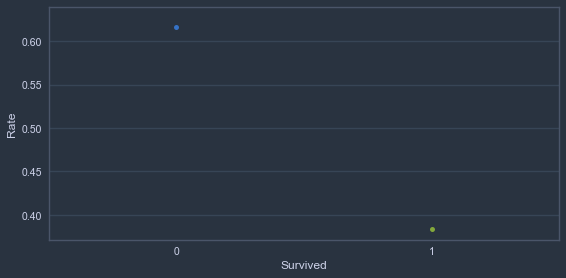

In [263]:
uni_cate_plot(train, 'Survived')

Survive Rate is 38.3%, which means the dataset is pretty skewed.


3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64


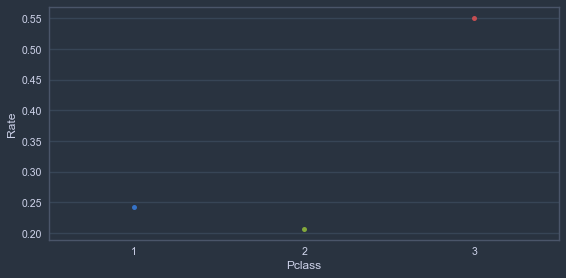

In [264]:
uni_cate_plot(train, 'Pclass')

First class passengers of all: 24.2%

Second class passengers: 20.7%

Third class passengers: 55%

male      0.647587
female    0.352413
Name: Sex, dtype: float64


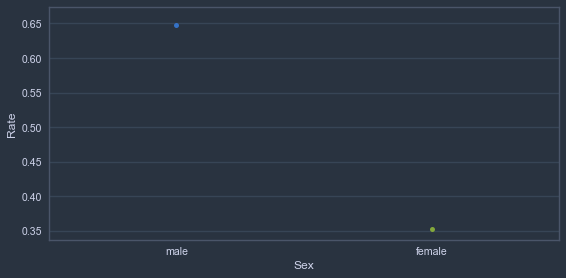

In [265]:
uni_cate_plot(train, 'Sex')

Male passengers: 64.8%
    
Female passengers: 35.2%

S    0.725028
C    0.188552
Q    0.086420
Name: Embarked, dtype: float64


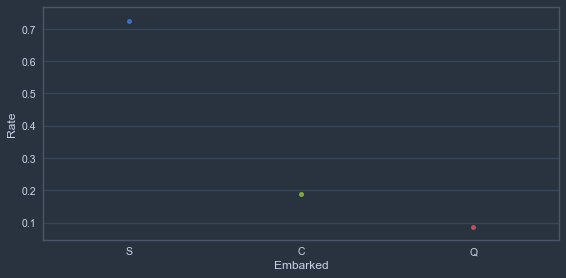

In [266]:
uni_cate_plot(train, 'Embarked')

C = Cherbourg, Q = Queenstown, S = Southampton

Embarkation Port for Sourthhampton, Queenstown, Cherbourg: 72.5%, 18.9%, 8.6%


1    0.602694
0    0.397306
Name: isAlone, dtype: float64


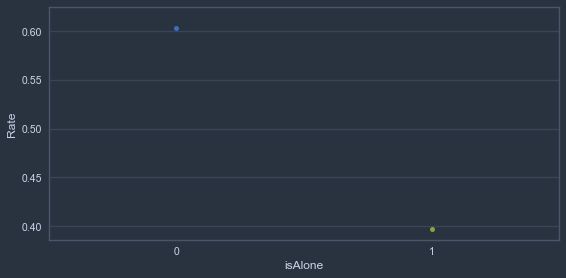

In [272]:
uni_cate_plot(train, 'isAlone')

40% of passengers are alone on this trip

Mr        0.580247
Miss      0.207632
Mrs       0.141414
Master    0.044893
Rare      0.025814
Name: Title, dtype: float64


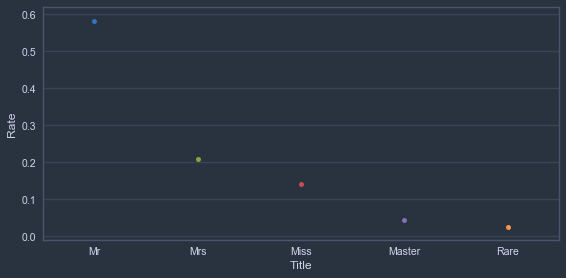

In [273]:
uni_cate_plot(train, 'Title')

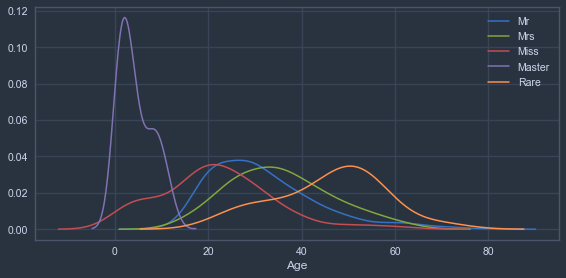

In [274]:
# Kenel Density Estimation 

for title in titles:   
    ax = sns.distplot(train[train.Title == title].Age.dropna(), hist=False, label = title)
plt.legend()

count    891.000000
mean      29.323423
std       13.618040
min        0.420000
25%       21.000000
50%       28.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64


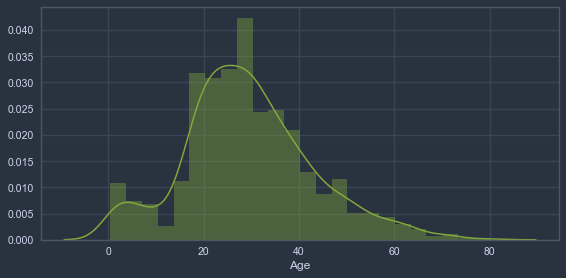

In [275]:
ax = sns.distplot(train.Age.dropna(), color="g")
print train.Age.describe()

Some interesting findings from the plots above are :

(1) Age distribution approximately follow a normal distritbion except for a bump on its left tail.

(2) Mean and standard deviation for the age are 30 and 13.5. 75% passengers are younger 37.

(3) members of Master group are mostly under 10 years old and accounts for 4.4% of the total travellers.  



Fare distribution looks like following a Pareto distribution. 75% fare is less than $31

In [276]:
familysizeCount = pd.DataFrame({'Counts' : train.FamilySize.value_counts()})
familysizeCount['Ratio'] = familysizeCount / len(train)
familysizeCount

,Counts,Ratio
1,537,0.602694
2,161,0.180696
3,102,0.114478
4,29,0.032548
6,22,0.024691
5,15,0.016835
7,12,0.013468
11,7,0.007856
8,6,0.006734


## Multivariate Analysis

In [284]:
categoricalFeatuers = ['Survived', 'Pclass', 'Sex', 'Embarked','isAlone', 'Title']
numericalFeatuers = ['Age', 'Fare' , 'FamilySize']

Since we are very interested in the variabes related to the Survival. The multivariate analysis and visulization will around the feature 'Survived'

In [278]:
def feature_weight(data, feature):
    return data[[feature, 'Survived']].groupby(feature, as_index=False).mean()
    

In [286]:
feature_weight(train, 'Pclass')

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


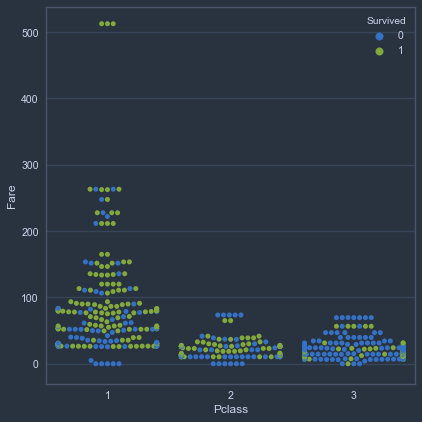

In [287]:
# Plots with feature 'Pclass', 'Fare', and 'Survived'
plt.figure(figsize=(6, 6))
ax = sns.swarmplot(x="Pclass", y="Fare", data=train, hue="Survived")



First Class tickets holders obviously has more chance to survive, espically for those highest fare tickets holders in the first class. 

In [289]:
# Sex
feature_weight(train, 'Sex')

,Sex,Survived
0,female,0.742038
1,male,0.188908


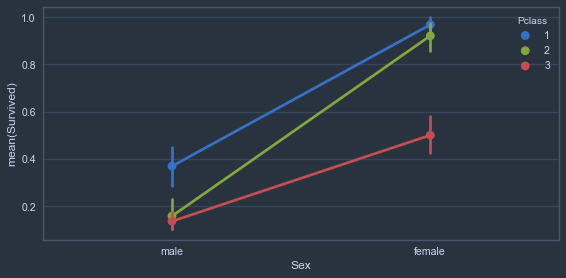

In [288]:
sns.pointplot(x="Sex", y="Survived", hue="Pclass", data=train);

Female survival rate much larger than male, especially for 1st and 2nd classes, more than 85%

In [290]:
# create Fanily size creature
for dataset in dataList:
    dataset['FamilySize'] = dataset.SibSp + dataset.Parch + 1

In [291]:
feature_weight(train, 'FamilySize')

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [293]:
plotFamilysize = feature_weight(train, 'FamilySize')
plotFamilysize['isAlone'] = False
plotFamilysize.loc[0, 'isAlone'] = True
plotFamilysize

,FamilySize,Survived,isAlone
0,1,0.303538,True
1,2,0.552795,False
2,3,0.578431,False
3,4,0.724138,False
4,5,0.200000,False
5,6,0.136364,False
6,7,0.333333,False
7,8,0.000000,False
8,11,0.000000,False


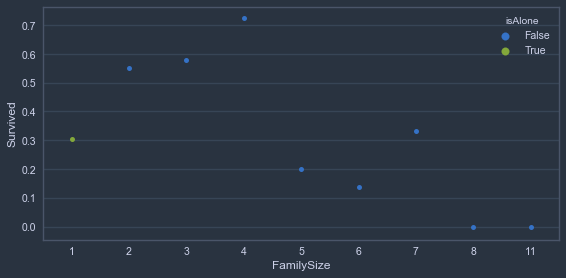

In [294]:
sns.stripplot(x="FamilySize", y="Survived", data=plotFamilysize, hue='isAlone')

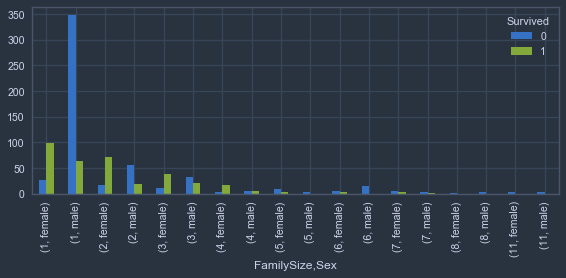

In [295]:
train.groupby(['FamilySize', 'Survived', 'Sex']).size().unstack('Survived').plot(kind = 'bar')

'Bachelors' on the Titanic are not likely(30%) to survive the titanic. 

Embarked     object
Survived    float64
dtype: object


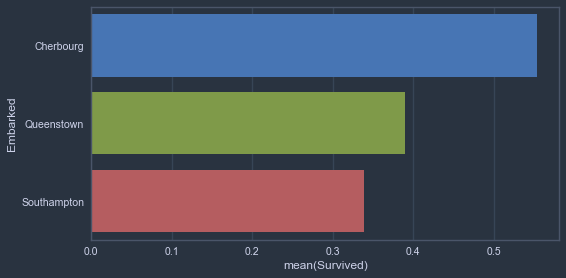

In [296]:

em_plot = feature_weight(train, 'Embarked')
ax = sns.barplot(x="Survived", y="Embarked", data=em_plot)
plt.yticks(xrange(3),('Cherbourg', 'Queenstown', 'Southampton'))
print em_plot.dtypes

Embarked at Cherbourg has higher survival rate 55.3%

In [297]:
feature_weight(train, 'Title')

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


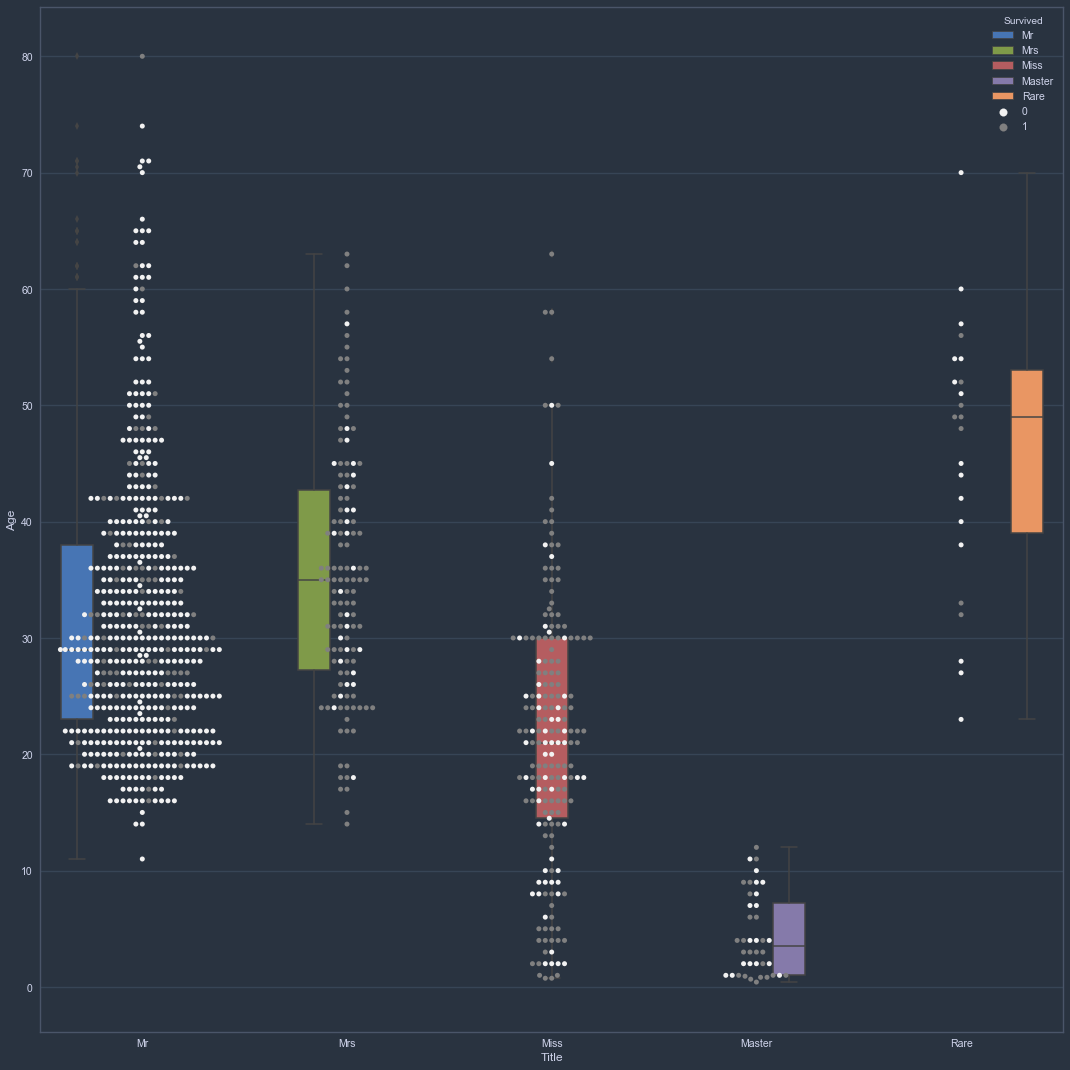

In [300]:
plt.figure(figsize=(15,15))
ax = sns.boxplot(x="Title", y="Age", hue="Title", data=train)
ax = sns.swarmplot(x="Title", y="Age", data=train, hue="Survived", color='0.5')


## Data Cleaning


In [817]:
# for dataset in dataList:
#     # mapping Sex
#     dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1})
#     # mapping title
#     titleMapping = { titles[e] : (e + 1) for e in range(len(titles)) }
#     dataset['Title'] = dataset['Title'].map(titleMapping)
#     # mapping Embarked
#     #dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q' : 2 })
    
    

In [1054]:
np.random.seed(10)

# Sample data randomly at fixed probabilities
voter_race = np.random.choice(a= ["asian","black","hispanic","other","white"],
                              p = [0.05, 0.15 ,0.25, 0.05, 0.5],
                              size=1000)

# Sample data randomly at fixed probabilities
voter_party = np.random.choice(a= ["democrat","independent","republican"],
                              p = [0.4, 0.2, 0.4],
                              size=1000)

voters = pd.DataFrame({"race":voter_race, 
                       "party":voter_party})

voter_tab = pd.crosstab(voters.race, voters.party, margins=True)

voter_tab.columns = ["democrat","independent","republican","row_totals"]

voter_tab.index = ["asian","black","hispanic","other","white","col_totals"]

observed = voter_tab.ix[0:5,0:3]   # Get table without totals for later use
voter_tab

,democrat,independent,republican,row_totals
asian,21,7,32,60
black,65,25,64,154
hispanic,107,50,94,251
other,15,8,15,38
white,189,96,212,497
col_totals,397,186,417,1000
